classificar em 2 a 8 hz

In [1]:
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import rfft, irfft, fftfreq
import scipy as sp
from scipy import signal

import os
import itertools

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [2]:
HOME = "/home/jonnatas/git/mlModels/sistema/modelo/DB_REPO/edf/"
def dadosPK(tipo):
    dir_ct = HOME+tipo+"/"
    return os.listdir(HOME+tipo+"/")

In [3]:
def carregarDataFrame(tipo, caminho):
    caminho = HOME+tipo+"/"+caminho
    
    edf = pyedflib.EdfReader(caminho)
    n = edf.signals_in_file
    sigbufs = np.zeros((n, edf.getNSamples()[0]))
    for i in np.arange(n):
         sigbufs[i, :] = edf.readSignal(i)
    edf._close()
    del edf

    return pd.DataFrame(data=sigbufs.T, columns=['ch1', 'ch2', 'ch3', 'ch4'])

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de confusão, sem normalização', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Esperado')
    plt.xlabel('Obtido')

In [5]:
def bandpass_filter(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    # create bandpass filter for EMG
    high = high_band/(sfreq/2)
    low = low_band/(sfreq/2)
    b, a = sp.signal.butter(4, [high,low], btype='bandpass')

    # process EMG signal: filter EMG
    return sp.signal.filtfilt(b, a, emg)

In [6]:
def lowpass_filter(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    return sp.signal.filtfilt(b2, a2, emg)

In [7]:
def fft(df, canal):
    amostras = int(df[canal][2000:11000].shape[0]*500/2000)
    sinal = np.abs(np.fft.fft(df[canal][2000:11000]))[:amostras]
    freq = np.linspace(0,500,amostras)
    return (sinal,freq)

def frequeciaBD(df, canal):
    sinalFFT = [bandpass_filter(fft(data, canal)[0]) for data in df]
    return sinalFFT

def frequecia(df, canal):
    sinalFFT = [fft(data, canal)[0] for data in df]
    return sinalFFT

def plotarFFT(a, b, titulo):
    plt.title(titulo)
    plt.plot(b,a)
    plt.xlim([0,500])
    plt.ylim([0,5000])
    plt.show

In [8]:
nomes_parkinson = dadosPK('parkinson')
nomes_controle = dadosPK('controle')
df_ct = [ carregarDataFrame('controle', nome) for nome in nomes_controle]
df_pk = [ carregarDataFrame('parkinson', nome) for nome in nomes_parkinson]

# Filtrando os dados com a fft

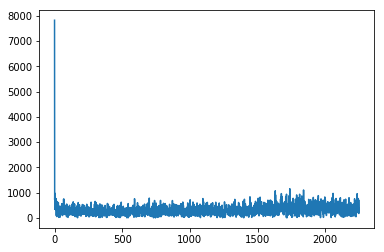

In [9]:
sinalCT = frequecia(df_ct, 'ch1')
sinalPK = frequecia(df_pk, 'ch1')

sinalCTBD = frequeciaBD(df_ct, 'ch1')
sinalPKBD = frequeciaBD(df_pk, 'ch1')

rotulosCT = [0 for _ in sinalCT]
rotulosPK = [1 for _ in sinalPK]
plt.plot(sinalCT[0])

## Separando os dados (Treino, teste e validação)

In [10]:
trainData = sinalCT + sinalPK
trainDataBD = sinalCT + sinalPK
rotulos = rotulosCT + rotulosPK

In [11]:
# Croos validation
X_train, X_test, y_train, y_test = train_test_split(trainData, rotulos, test_size=0.2, random_state=0)
X_trainBD, X_testBD, y_trainBD, y_testBD = train_test_split(trainDataBD, rotulos, test_size=0.2, random_state=0)
#X_validate, X_test, y_validade, y_test = train_test_split(X_test, y_test, test_size=0.5)

# Croos validation
X_train, X_test, y_train, y_teste = train_test_split(trainData, rotulos, test_size=0.3)

## Selhecionando melhores parametros

In [12]:
param_grid = [
    #{'C': [10, 1, 0.1], 'gamma': [0.001, 0.0001], 'kernel':['sigmoid']}
    {'C': [10, 1, 0.1], 'gamma': [0.001, 0.0001], 'kernel':['poly'], 'degree':[3,4]}
]

In [13]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
gridBD = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

## Treinando

In [14]:
grid.fit(X_train, y_train)
gridBD.fit(X_trainBD, y_trainBD)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=10, degree=3, gamma=0.001, kernel=poly ........................
[CV]  C=10, degree=3, gamma=0.001, kernel=poly, score=0.6956521739130435, total=   0.0s
[CV] C=10, degree=3, gamma=0.001, kernel=poly ........................
[CV]  C=10, degree=3, gamma=0.001, kernel=poly, score=0.6818181818181818, total=   0.0s
[CV] C=10, degree=3, gamma=0.001, kernel=poly ........................
[CV]  C=10, degree=3, gamma=0.001, kernel=poly, score=0.5454545454545454, total=   0.0s
[CV] C=10, degree=3, gamma=0.0001, kernel=poly .......................
[CV]  C=10, degree=3, gamma=0.0001, kernel=poly, score=0.6956521739130435, total=   0.0s
[CV] C=10, degree=3, gamma=0.0001, kernel=poly .......................
[CV]  C=10, degree=3, gamma=0.0001, kernel=poly, score=0.6818181818181818, total=   0.0s
[CV] C=10, degree=3, gamma=0.0001, kernel=poly .......................
[CV]  C=10, degree=3, gamma=0.0001, kernel=poly, score=0.54545454545454

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1, degree=3, gamma=0.001, kernel=poly, score=0.6956521739130435, total=   0.0s
[CV] C=1, degree=3, gamma=0.001, kernel=poly .........................
[CV]  C=1, degree=3, gamma=0.001, kernel=poly, score=0.6818181818181818, total=   0.0s
[CV] C=1, degree=3, gamma=0.001, kernel=poly .........................
[CV]  C=1, degree=3, gamma=0.001, kernel=poly, score=0.5454545454545454, total=   0.0s
[CV] C=1, degree=3, gamma=0.0001, kernel=poly ........................
[CV]  C=1, degree=3, gamma=0.0001, kernel=poly, score=0.6956521739130435, total=   0.0s
[CV] C=1, degree=3, gamma=0.0001, kernel=poly ........................
[CV]  C=1, degree=3, gamma=0.0001, kernel=poly, score=0.6818181818181818, total=   0.0s
[CV] C=1, degree=3, gamma=0.0001, kernel=poly ........................
[CV]  C=1, degree=3, gamma=0.0001, kernel=poly, score=0.5454545454545454, total=   0.0s
[CV] C=1, degree=4, gamma=0.001, kernel=poly .........................
[CV]  C=1, degree=4, gamma=0.001, kernel=poly, sc

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=10, degree=3, gamma=0.001, kernel=poly, score=0.5454545454545454, total=   0.0s
[CV] C=10, degree=3, gamma=0.0001, kernel=poly .......................
[CV]  C=10, degree=3, gamma=0.0001, kernel=poly, score=0.6956521739130435, total=   0.0s
[CV] C=10, degree=3, gamma=0.0001, kernel=poly .......................
[CV]  C=10, degree=3, gamma=0.0001, kernel=poly, score=0.6818181818181818, total=   0.0s
[CV] C=10, degree=3, gamma=0.0001, kernel=poly .......................
[CV]  C=10, degree=3, gamma=0.0001, kernel=poly, score=0.5454545454545454, total=   0.0s
[CV] C=10, degree=4, gamma=0.001, kernel=poly ........................
[CV]  C=10, degree=4, gamma=0.001, kernel=poly, score=0.7391304347826086, total=   0.0s
[CV] C=10, degree=4, gamma=0.001, kernel=poly ........................
[CV]  C=10, degree=4, gamma=0.001, kernel=poly, score=0.7272727272727273, total=   0.0s
[CV] C=10, degree=4, gamma=0.001, kernel=poly ........................
[CV]  C=10, degree=4, gamma=0.001, kernel=p

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [10, 1, 0.1], 'gamma': [0.001, 0.0001], 'kernel': ['poly'], 'degree': [3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [15]:
y_pred = grid.predict(X_test)
y_predBD = gridBD.predict(X_testBD)

## Validando

In [20]:
nomes = ['parkinson', 'controle']

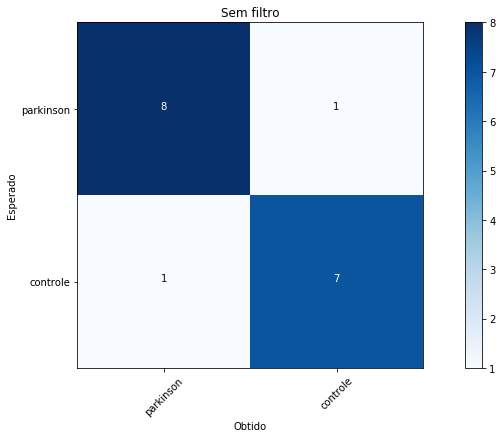

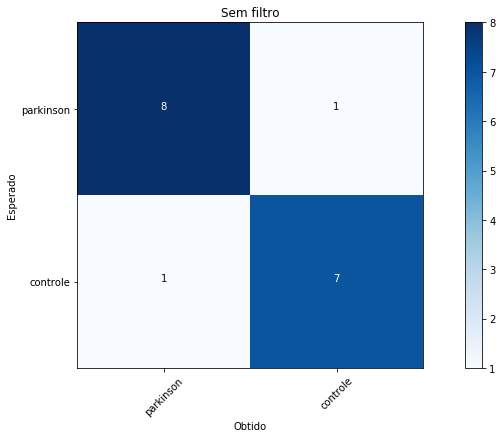

In [21]:
plot_confusion_matrix(cnf_matrix, classes=nomes, title="Sem filtro")
plot_confusion_matrix(cnf_matrix, classes=nomes, title="Sem filtro")

<Figure size 432x288 with 0 Axes>

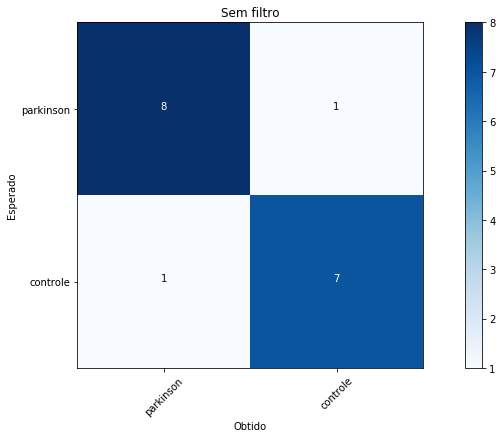

In [17]:
# Matriz de confusão
cnf_matrix = confusion_matrix(y_test, y_pred )
np.set_printoptions(precision=2)
# Sem normalização
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=nomes, title="Sem filtro")

<Figure size 432x288 with 0 Axes>

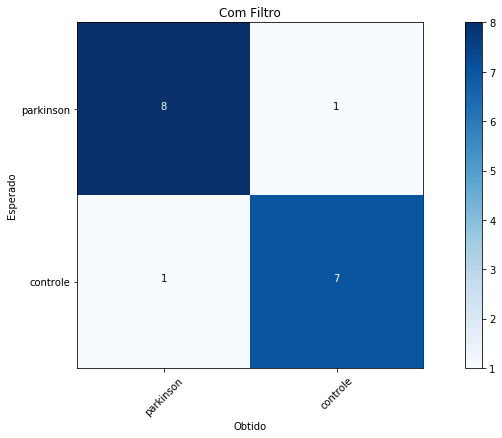

In [18]:
# Matriz de confusão
cnf_matrix = confusion_matrix(y_testBD, y_predBD )
np.set_printoptions(precision=2)
# Sem normalização
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=nomes, title="Com Filtro")

In [19]:
print("Sem filtro")
print(classification_report(y_pred, y_test))
print("Com filtro")
print(classification_report(y_predBD, y_testBD))

Sem filtro
             precision    recall  f1-score   support

          0       0.89      0.89      0.89         9
          1       0.88      0.88      0.88         8

avg / total       0.88      0.88      0.88        17

Com filtro
             precision    recall  f1-score   support

          0       0.89      0.89      0.89         9
          1       0.88      0.88      0.88         8

avg / total       0.88      0.88      0.88        17

